# **Time Series Forecasting**

## **Introduction**

In this Jupyter notebook, we create statistical models to forecast future taxi trips in 20 regions out of the 83 composing Chicago.

In the previous notebook, "Time_Series_Exploration", we saw that we can decompose each taxi flow into 3 components:

*   seasonal flow, capturing the daily periodicity
*   trend flow, capturing the changes in taxi level demand
*   and residual flows for instantaneous changes due to social events, weather, or holidays

Based on those findings, we select the statistical models most adapted to this type of time series. We will try the following:

*   SARIMA
*   TBATS
*   VAR
*   Fourier Series Transform

Before that, let's setup the environment!




## **Setting up the environment**

In [ ]:
regionIDsSelected = [[26, 365168.0], [53, 26872.0], [60, 459962.0], [62, 15995.0], [65, 18050.0], [66, 2536978.0], [67, 21184.0], [68, 59604.0], [72, 750790.0], [73, 96074.0], [75, 155855.0], [76, 716215.0], [77, 1399092.0], [78, 496385.0], [80, 30788.0], [82, 64346.0], [83, 427156.0], [88, 86480.0], [100, 62372.0], [125, 107300.0]]

In [ ]:
#Libraries needed in this notebook
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import math
import timeSeriesMatrix


data = np.loadtxt("/content/timeseriesuptodec.csv", delimiter=',')

In [ ]:
!pip install ipython-autotime

%load_ext autotime

In [ ]:
def returnNewFlowTimeSeriesMatrix(taxiTimeSeriesMatrix):
  n = len(taxiTimeSeriesMatrix)
  m = len(taxiTimeSeriesMatrix[0])

  newFlowTimeSeriesMatrix = []
  i = 0
  while i < n:
    newFlowTimeSeriesArray = []
    j = 0
    while j < m:
      newFlowTimeSeriesArray.append(taxiTimeSeriesMatrix[i][j])
      j = j + 2
    newFlowTimeSeriesMatrix.append(newFlowTimeSeriesArray)
    i = i + 1
  
  return newFlowTimeSeriesMatrix

def returnEndFlowTimeSeriesMatrix(taxiTimeSeriesMatrix):
  n = len(taxiTimeSeriesMatrix)
  m = len(taxiTimeSeriesMatrix[0])

  endFlowTimeSeriesMatrix = []
  i = 0
  while i < n:
    endFlowTimeSeriesArray = []
    j = 1
    while j < m:
      endFlowTimeSeriesArray.append(taxiTimeSeriesMatrix[i][j])
      j = j + 2
    endFlowTimeSeriesMatrix.append(endFlowTimeSeriesArray)
    i = i + 1

  return endFlowTimeSeriesMatrix

time: 20.9 ms


In [ ]:
newFlowTimeSeriesMatrix = returnNewFlowTimeSeriesMatrix(data)
endFlowTimeSeriesMatrix = returnEndFlowTimeSeriesMatrix(data)

time: 553 ms


## **Statistical Analysis**

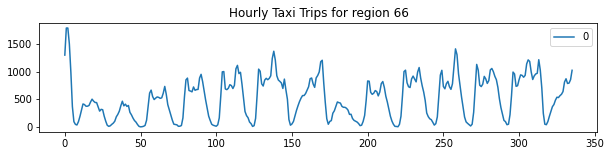

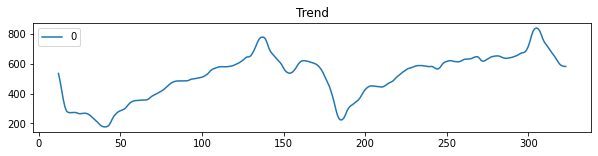

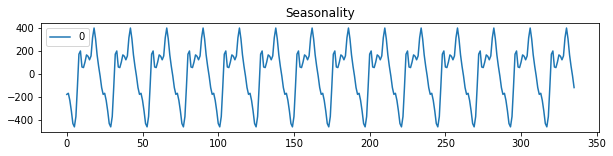

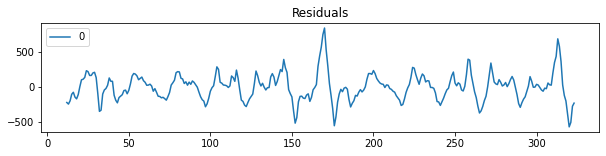

In [ ]:
regionIDSelected = 66

startIndex = 0
endIndex = 24*14
regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)

df = pd.DataFrame(newFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex])

decomposition = sm.tsa.seasonal_decompose(df, model='additive', freq=24)
decomposition.observed.plot(figsize=(10,2), title='Hourly Taxi Trips for region ' + str(regionIDSelected))
decomposition.trend.plot(figsize=(10,2), title='Trend')
decomposition.seasonal.plot(figsize=(10,2), title='Seasonality')
decomposition.resid.plot(figsize=(10,2), title='Residuals')

Now, we check formally whether the data is stationary or not using the Augmented Dickey-Fuller test.

In [ ]:
def test_stationarity(data):
    p_val=adfuller(data)[1]
    if p_val >= 0.05:
        print("Time series data is not stationary. Adfuller test pvalue={}".format(p_val))
    else:
        print("Time series data is stationary. Adfuller test pvalue={}".format(p_val))
test_stationarity(newFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex]) 

Time series data is stationary. Adfuller test pvalue=3.034070036761668e-08


## **RMSE implementation**

We implement the function that computes the Root Mean Squarred Error (RMSE) to evaluate each model.

In [ ]:
def returnRMSEFor(timeSeriesForecast, timeSeriesReal):
  n = len(timeSeriesForecast)
  if len(timeSeriesReal) != n:
    print("error : RMSE , not same sizes arrays")
    return -1
  i = 0 
  mse = 0
  while i < n:
    if timeSeriesForecast[i] < 0:
      timeSeriesForecast[i] = 0
    mse = mse + (timeSeriesForecast[i] - timeSeriesReal[i])**2
    i = i + 1
  rmse = (mse/n)**0.5
  return rmse

def returnMSESumFor(timeSeriesForecast, timeSeriesReal):
  n = len(timeSeriesForecast)
  if len(timeSeriesReal) != n:
    print("error : RMSE , not same sizes arrays")
    return -1
  i = 0 
  mse = 0
  while i < n:
    if timeSeriesForecast[i] < 0:
      timeSeriesForecast[i] = 0
    mse = mse + (timeSeriesForecast[i] - timeSeriesReal[i])**2
    i = i + 1
  return mse

def returnMAEFor(timeSeriesForecast, timeSeriesReal):
  n = len(timeSeriesForecast)
  if len(timeSeriesReal) != n:
    return 10000000
  i = 0 
  mae = 0
  while i < n:
    mae = mae + abs(timeSeriesForecast[i] - timeSeriesReal[i])
    i = i + 1
  
  return mae/n

time: 20.6 ms


## **Exogenous variable: Day type**

The first exogenous variable we include to help forecast taxi trips is the day type. Looking at the various plots, we clearly see that the level of taxi demand increases from Monday to Thursday, then from Friday to Sunday, it decreases. On holidays falling during the week, we see that the taxi demand level is highly impacted. 


We adopt a very simple encoding for each day from January to December. We encode Monday as 1, Tuesday as 2, etc up to Sunday as 7.

When the day is a holiday, regardless of the type of holiday (Thanksgiving, or Christmas), we encode it as 8.
We know beforehand, each holiday has a different and sometimes opposite effect on taxi trips demand. Let's first see the impact of this encoding on the noise/residuals.


We follow the encoding of the library "datetime" in python:
date.isoweekday(): return the day of the week as an integer, where Monday is 1 and Sunday is 7.



In [ ]:
!pip install holidays

In [ ]:
import datetime
from datetime import date
from datetime import timedelta

import holidays

us_holidays = holidays.UnitedStates()

holidayEncoding = 0

def isDateaHoliday(dateValue):
  if dateValue in us_holidays:
    return 'Holiday'
  return ""

#checks the day type
def returndayTypeEncoding(dateValue):
  if isDateaHoliday(dateValue):
    return holidayEncoding
  return date(dateValue.year,dateValue.month,dateValue.day ).isoweekday()

def returnDayTypeArray(initialDate, timeRangeInHours = 24*365):
  dayTypeEncodingArray = []
  initialDateofArray = datetime.datetime.strptime(initialDate, "%Y-%m-%d")
  i = 0
  numberOfDays, remainingHours = divmod(timeRangeInHours, 24)

  while i < numberOfDays: 
    newDate = initialDateofArray + datetime.timedelta(days=i)
    newDateEncoding = returndayTypeEncoding(newDate)
    newArrayToAdd = [newDateEncoding] * 24
    dayTypeEncodingArray = dayTypeEncodingArray + newArrayToAdd
    i = i + 1
  
  if remainingHours > 0:
    newDate = initialDateofArray + datetime.timedelta(days=i)
    newDateEncoding = returndayTypeEncoding(newDate)
    newArrayToAdd = [newDateEncoding] * remainingHours
    dayTypeEncodingArray = dayTypeEncodingArray + newArrayToAdd
  
  return dayTypeEncodingArray

time: 26.1 ms


In [ ]:
def returnFullDateArray(initialDateWithTime, timeRangeinHours = 24*365):
  fullDateArray = pd.date_range(pd.Timestamp(initialDateWithTime),
                    periods=timeRangeinHours, freq='h')

  return fullDateArray

fullDateArray2017 = returnFullDateArray("2017-01-01 00:00")
print(fullDateArray2017.shape)

(8760,)
time: 4.35 ms


In [ ]:
dayTypeEncoding2017 = returnDayTypeArray("2017-01-01")

time: 10.6 ms


In [ ]:
ny = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2016-01-01', '2017-01-01'])})  
mlk = pd.DataFrame({'holiday': 'Birthday of Martin Luther King, Jr.', 'ds' : pd.to_datetime(['2016-01-18', '2017-01-16'])}) 
wash = pd.DataFrame({'holiday': "Washington's Birthday", 'ds' : pd.to_datetime(['2016-02-15', '2017-02-20'])})
mem = pd.DataFrame({'holiday': 'Memorial Day', 'ds' : pd.to_datetime(['2016-05-30', '2017-05-29'])})
ind = pd.DataFrame({'holiday': 'Independence Day', 'ds' : pd.to_datetime(['2015-07-04', '2016-07-04', '2017-07-04'])})
lab = pd.DataFrame({'holiday': 'Labor Day', 'ds' : pd.to_datetime(['2015-09-07', '2016-09-05', '2017-09-04'])})
col = pd.DataFrame({'holiday': 'Columbus Day', 'ds' : pd.to_datetime(['2015-10-12', '2016-10-10', '2017-10-09'])})
vet = pd.DataFrame({'holiday': "Veteran's Day", 'ds' : pd.to_datetime(['2015-11-11', '2016-11-11', '2017-11-11'])})
thanks = pd.DataFrame({'holiday': 'Thanksgiving Day', 'ds' : pd.to_datetime(['2015-11-26', '2016-11-24'])})
christ = pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2015-12-25', '2016-12-25'])})
inaug = pd.DataFrame({'holiday': 'Inauguration Day', 'ds' : pd.to_datetime(['2017-01-20'])})

us_public_holidays = pd.concat([ny, mlk, wash, mem, ind, lab, col, vet, thanks, christ, inaug])

## **TBATS**

We install the library to use the TBATS model.

In [ ]:
!pip install tbats

We first try one forecasting on the time series for region ID 66 (the busiest one). 

In [ ]:
startIndex = 24*72
endIndex = 24*273

regionIDSelected = 66

regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)

y_to_train = newFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex]

time: 2.32 ms


In [ ]:
from tbats import TBATS, BATS
# Fit the model
estimator = TBATS(seasonal_periods=(24, 24*7))
model = estimator.fit(y_to_train)
# Forecast 1 day ahead
y_forecast = model.forecast(steps=24*7*4)

time: 32min 36s


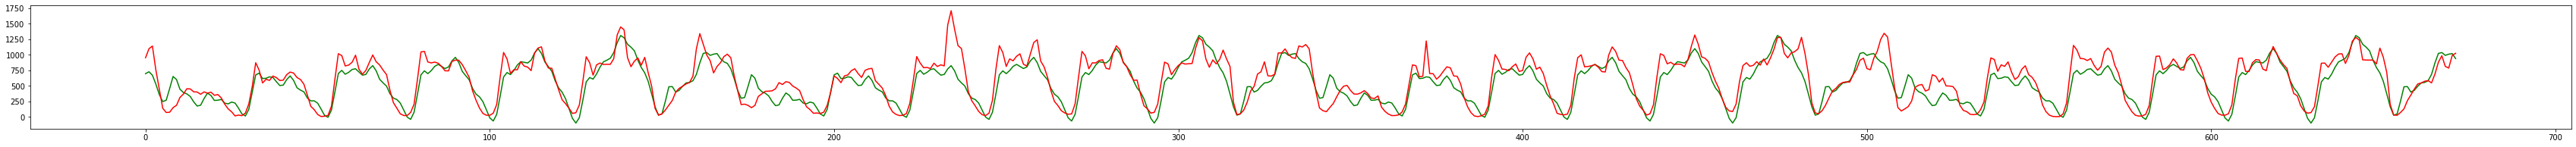

time: 309 ms


In [ ]:
plt.plot( y_forecast, 'g', newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+24*7*4], 'r')
plt.rcParams["figure.figsize"] = (10,4)
plt.show()

In [ ]:
mae = returnMAEFor(y_forecast, newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+24*7*4])

total = np.sum(newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+24*7*4])

meanTaxiTripsPerHour = total/(24*7*4)

print(meanTaxiTripsPerHour)

print("MAE for TBATS for region 66 :", mae)
print(mae/meanTaxiTripsPerHour)

604.110119047619
RMSE for TBATS for region 66 : 139.71476006491892
0.23127366296260615
time: 10.3 ms


Without ever seeing the month of October, TBATS model managed to forecast very closely the time series of new flows of taxis for region 66 for the entire month of October 2017. The Mean Absolute Error (MAE) is equal to 139.71, or about 23% of the average number of taxi trips per hour.

A better model could be constructed on one year of data. Therefore, we will include the time series from October to end of December 2016 and include them to the data for training.

other test

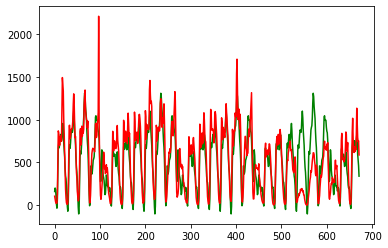

time: 36min 43s


In [ ]:
from tbats import TBATS, BATS

startIndex = 0
endIndex = 24*304

regionIDSelected = 66

regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)

y_to_train = newFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex]

# Fit the model
estimator = TBATS(seasonal_periods=(24, 24*7))
model = estimator.fit(y_to_train)
# Forecast 1 day ahead
y_forecast = model.forecast(steps=24*7*4)

plt.plot( y_forecast, 'g', newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+24*7*4], 'r')
plt.rcParams["figure.figsize"] = (10,4)
plt.show()



In [ ]:
mae = returnMAEFor(y_forecast, newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+24*7*4])

total = np.sum(newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+24*7*4])

meanTaxiTripsPerHour = total/(24*7*4)

print(meanTaxiTripsPerHour)

print("MAE for TBATS for region 66 :", mae)
print(mae/meanTaxiTripsPerHour)

543.9002976190476
MAE for TBATS for region 66 : 169.72773650572145
0.3120567082767074
time: 6.24 ms


**Forecast the 2 flows for all regions**

Now, we create a function to iterate through the two flows for all the 20 regions.

In [ ]:
def returnTBATSForecastFor(yToTrain, periodToForecast):
  # Fit the model
  estimator = TBATS(seasonal_periods=(24, 24*7))
  model = estimator.fit(yToTrain)
  # Forecast 1 day ahead
  y_forecast = model.forecast(steps=periodToForecast)

  return y_forecast

time: 2.52 ms


In [ ]:
startIndex = 0
endIndex = 24*304
predictRange = 24*7*4

i = 0 
n = 20

forecastsMatrix = []

while i < n:
  regionIDSelected = regionIDsSelected[i][0]
  regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)
  
  #new flow forecast
  y_to_train = newFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex]
  y_forecast = returnTBATSForecastFor(y_to_train, predictRange)

  forecastsMatrix.append(y_forecast)

  print("Region ID :", regionIDSelected)
  
  print("New-flow forecasted :", y_forecast)
  
  #end flow forecast
  y_to_train = endFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex]
  y_forecast = returnTBATSForecastFor(y_to_train, predictRange)
  forecastsMatrix.append(y_forecast)
  print("End-flow forecasted :", y_forecast)

  print()
  print("-----")

  #next region
  i = i + 1

In [ ]:
def returnSquarredDifference(yForecast, realTimeSeries):
  m = len(yForecast) 
   
  if len(yForecast) != len(realTimeSeries):
    print ("error : arrays not with same length")
    return -1

  squarredDifference = 0
  j = 0
  while j < m:
    if yForecast[j] < 0:
      yForecast[j] = 0
    squarredDifference = squarredDifference + (yForecast[j]-realTimeSeries[j])**2
    j = j + 1
  
  return squarredDifference

i = 0
n = 6

periodsForecastsArray = [24, 24*7, 24*7*2, 24*7*4]

squarredDifferenceSum = 0
squarredDifferenceSumArray = [0, 0, 0, 0]
l = 0
while i < n:
  l = 0
  while l < len(periodsForecastsArray):
    periodForecasted = periodsForecastsArray[l]
    k = int(i/2)
    regionIDSelected = regionIDsSelected[k][0]
    regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)
    
    new_flow_y_forecast = forecastsMatrix[i][:periodForecasted]
    new_flow_real = newFlowTimeSeriesMatrix[regionIDIndex][endIndex: endIndex + periodForecasted]
    
    squarredDifferenceSum1 = returnSquarredDifference(new_flow_y_forecast, new_flow_real)

    print("Region ID :", regionIDSelected)
    print("Period :", periodForecasted)
    print("New flow difference: ", squarredDifferenceSum1)
    end_flow_y_forecast = forecastsMatrix[i+1][:periodForecasted]
    end_flow_real = endFlowTimeSeriesMatrix[regionIDIndex][endIndex: endIndex + periodForecasted]
    
    squarredDifferenceSum2 = returnSquarredDifference(end_flow_y_forecast, end_flow_real)
    print("End flow difference: ", squarredDifferenceSum2)
    print("")
    print("-----------")

    prevValue = squarredDifferenceSumArray[l]
    squarredDifferenceSumArray[l] = prevValue + squarredDifferenceSum1 + squarredDifferenceSum2

    l = l + 1
  i = i + 2

Region ID : 26
Period : 24
New flow difference:  194632.5198591565
End flow difference:  45887.5987626592

-----------
Region ID : 26
Period : 168
New flow difference:  699219.7994395808
End flow difference:  137459.44717422634

-----------
Region ID : 26
Period : 336
New flow difference:  1445055.9035598715
End flow difference:  362361.5498499966

-----------
Region ID : 26
Period : 672
New flow difference:  2837396.8207102763
End flow difference:  1227397.8281395154

-----------
Region ID : 53
Period : 24
New flow difference:  264.465370950755
End flow difference:  482.5819801240988

-----------
Region ID : 53
Period : 168
New flow difference:  2445.150689247352
End flow difference:  7475.395638247198

-----------
Region ID : 53
Period : 336
New flow difference:  6799.066597145891
End flow difference:  11806.462759021646

-----------
Region ID : 53
Period : 672
New flow difference:  18616.982656546934
End flow difference:  23872.50620680532

-----------
Region ID : 60
Period : 24
New

In [ ]:
print(squarredDifferenceSumArray)

[308544.2799984962, 2389665.8476134352, 4452539.54987333, 10806000.06199315]
time: 1.4 ms


In [ ]:
squarredError_24 = np.sum([28.68921984029904, 962.0566279482339, 184.49255119224273, 2119.494820245538, 90165.64483928673, 138466.25280804702])

squarredError_247 = np.sum([691.5179629161362, 8495.874286438568, 16971.924654855786, 24776.768886500733, 819882.909306487, 1018364.7976973422])

squarredError_2472 = np.sum([1136.8160144037001, 13856.712314938628, 28086.896879042277, 39934.10627556374, 1109542.9914243903, 1362043.4376867572])

squarredError_2474 = np.sum([2092.510259105539, 29517.349484450526, 67427.56445077903, 124925.50929216329, 3001653.2906347513, 3130974.310771121])

squarredDifferenceSumArray_2 = [squarredError_24, squarredError_247, squarredError_2472, squarredError_2474 ]

print(squarredDifferenceSumArray_2)


[231926.63086656007, 1889183.7927945405, 2554600.960595096, 6356590.534892371]
time: 4.37 ms


In [ ]:
squarredError_24 = np.sum([13.467463549023503, 256.61848955405117, 27.493991102458278, 125.98942113602891, 1164520.975543475, 722398.759617698])

squarredError_247 = np.sum([193.06871038064045, 6387.152911563766, 1752.8094836506398, 3771.768385812717, 7050864.062901654, 4082919.181988423])

squarredError_2472 = np.sum([482.21807625357104, 11674.296014056064, 2751.6041528969413, 7957.042547534711, 13425693.393733483, 7199258.737328069 ])

squarredError_2474 = np.sum([929.552120906708, 24436.515851955795, 4876.865862495916, 21279.785108012726, 35546325.50278524, 29797195.73704557])

squarredDifferenceSumArray_3 = [squarredError_24, squarredError_247, squarredError_2472, squarredError_2474 ]

print(squarredDifferenceSumArray_3)

[1887343.3045265144, 11145888.044381484, 20647817.291852295, 65395043.95877419]
time: 5.14 ms


In [ ]:
squarredError_24 = np.sum([4358.686191351952, 1428.0255219440728, 1279.8839603789982, 5077.918970048204, 124418.83460274887, 60693.289114240935])

squarredError_247 = np.sum([47886.06028212953, 56074.80743599023, 44041.39040751893, 40054.268683059454, 483663.1498245333, 279284.30767859035 ])

squarredError_2472 = np.sum([102328.62559589837, 82570.8716948402, 85627.90213719111, 108612.81916473049, 853010.9994335613, 526966.9916665074 ])

squarredError_2474 = np.sum([216790.58930516124, 159275.4016930918, 251579.85453612747, 367260.4091450104, 3352401.4325155416, 2238270.2168975696 ])

squarredDifferenceSumArray_4 = [squarredError_24, squarredError_247, squarredError_2472, squarredError_2474 ]

print(squarredDifferenceSumArray_4)

[197256.63836071303, 951003.9843118219, 1759118.209692729, 6585577.904092502]
time: 10.5 ms


In [ ]:
squarredDifferenceSumArray_5 = [49793.31389924414, 830605.2765898502, 1098147.2827987578, 2132912.883706036]
squarredDifferenceSumArray_6 = [133791.80914480344, 454909.07379195263, 789029.7014988106, 2895211.4655538173]
squarredDifferenceSumArray_7 = [460387.0690133739, 4391521.2422423065, 8129793.992927176, 36393058.00625238]

time: 4.65 ms


In [ ]:
squarredDifferenceSumArrayTotal = [0, 0, 0, 0]

i = 0 
n = 4
sum = 0
while i < n:
  sum = squarredDifferenceSumArray[i] + squarredDifferenceSumArray_2[i] + squarredDifferenceSumArray_3[i] + squarredDifferenceSumArray_4[i]
  sum = sum + squarredDifferenceSumArray_5[i] + squarredDifferenceSumArray_6[i] + squarredDifferenceSumArray_7[i]
  squarredDifferenceSumArrayTotal[i] = sum
  i = i + 1

prevValue = squarredDifferenceSumArrayTotal[0] / (2*24*20)
squarredDifferenceSumArrayTotal[0] = prevValue

prevValue = squarredDifferenceSumArrayTotal[1] / (2*24*20*7)
squarredDifferenceSumArrayTotal[1] = prevValue

prevValue = squarredDifferenceSumArrayTotal[2] / (2*24*20*7*2)
squarredDifferenceSumArrayTotal[2] = prevValue

prevValue = squarredDifferenceSumArrayTotal[3] / (2*24*20*7*4)
squarredDifferenceSumArrayTotal[3] = prevValue

i = 0 
n = 4

while i < n:
  prevValue = squarredDifferenceSumArrayTotal[i]
  squarredDifferenceSumArrayTotal[i] = (prevValue)**0.5
  i = i + 1

print(squarredDifferenceSumArrayTotal)

[58.354547146888585, 57.28580350309184, 54.165096352630506, 69.69437821470639]
time: 13.7 ms


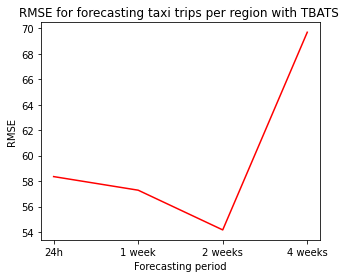

time: 123 ms


In [ ]:
xLabels = ["24h", "1 week", "2 weeks", "4 weeks"]

plt.title('RMSE for forecasting taxi trips per region with TBATS ')
plt.xlabel('Forecasting period')
plt.ylabel('RMSE')
plt.plot( xLabels, squarredDifferenceSumArrayTotal, 'r')
plt.rcParams["figure.figsize"] = (5,4)
plt.show()

## **SARIMA**

In [ ]:
!pip install pmdarima

In [ ]:
startIndex = 24*120
endIndex = 24*273

regionIDSelected = 66

regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)

y_to_train_arima = newFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex]

time: 2.25 ms


In [ ]:
from pmdarima import auto_arima

arima_model = auto_arima(y_to_train_arima, seasonal=True, m=24)
y_arima_forecast = arima_model.predict(n_periods=24)

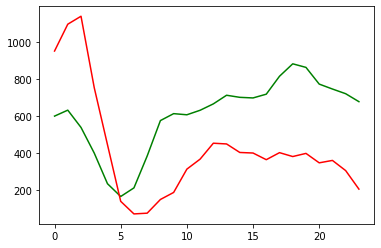

time: 209 ms


In [ ]:
plt.plot( y_arima_forecast, 'g', newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+24], 'r')
plt.rcParams["figure.figsize"] = (40,4)
plt.show()

In [ ]:
mae = returnMAEFor(y_arima_forecast, newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+24])

total = np.sum(newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+24])

meanTaxiTripsPerHour = total/(24)

print(meanTaxiTripsPerHour)

print("MAE for TBATS for region 66 :", mae)
print(mae/meanTaxiTripsPerHour)

423.0
MAE for TBATS for region 66 : 348.70236262405024
0.8243554671963362
time: 4.13 ms


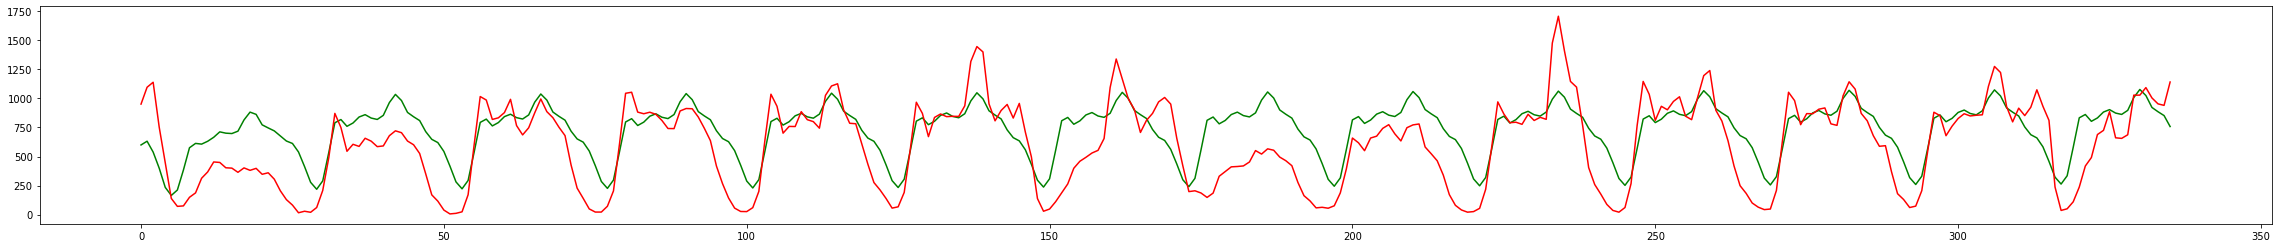

time: 291 ms


In [ ]:
y_arima_forecast = arima_model.predict(n_periods=24*7*2)

plt.plot( y_arima_forecast, 'g', newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+24*7*2], 'r')
plt.rcParams["figure.figsize"] = (40,4)
plt.show()

In [ ]:
mae = returnMAEFor(y_arima_forecast, newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+24*7*2])

total = np.sum(newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+24*7*2])

meanTaxiTripsPerHour = total/(24*7*2)

print(meanTaxiTripsPerHour)

print("MAE for SARIMA for region 66 :", mae)
print(mae/meanTaxiTripsPerHour)

601.75
MAE for SARIMA for region 66 : 220.1903761208667
0.3659167031505886
time: 4.02 ms


## **Exponential smoothing**

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def returnExponentialSmoothingForecast(yToTrain, periodToForecast):
  model = ExponentialSmoothing(yToTrain, trend = "add", damped = True, seasonal="add", seasonal_periods=24).fit()
  yhat = model.predict(start=0, end=periodToForecast - 1)
  return yhat

def plotExpoSmoothingForecastVersusReal(yForecast, timeseriesReal):
  plt.plot(yForecast, "g", timeseriesReal, "r")
  plt.rcParams["figure.figsize"] = (80,4)

time: 5.43 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Taxi Trips forecast for 4 weeks for region ID 66


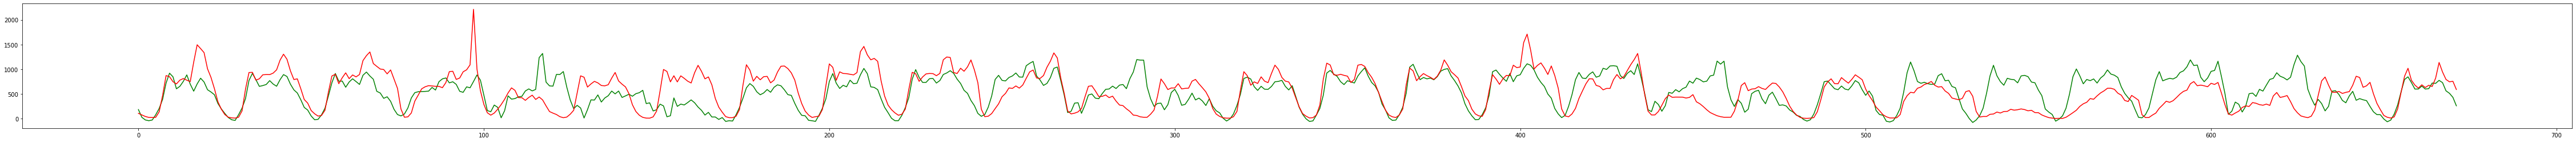

time: 2.51 s


In [ ]:
startIndex = 24*240
endIndex = 24*304
predictRange = 24*7*4

regionIDSelected = 66
regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)
  
#new flow forecast
y_to_train = newFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex]
y_forecast = returnExponentialSmoothingForecast(y_to_train, predictRange)

print("Taxi Trips forecast for 4 weeks for region ID 66")
plotExpoSmoothingForecastVersusReal(y_forecast, newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+predictRange])

In [ ]:
print(returnRMSEFor(y_forecast[:24*7*4], newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+predictRange][:24*7*4]))

print(returnMAEFor(y_forecast[:24*7*4], newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+predictRange][:24*7*4]))

93.42336723606677
67.09936662568506
time: 11.6 ms


**Running forecasts for all regions**

In [ ]:
startIndex = 24*240
endIndex = 24*304
predictRange = 24*7*4

i = 0
n = 20

periodsForecastsArray = [24, 24*7, 24*7*2, 24*7*4]
MSESumMatrix = [0, 0, 0, 0]

regionsForecastedNewEndFlow = 20 * 2

while i < n:
  regionIDSelected = regionIDsSelected[i][0]
  regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)

  print(regionIDSelected)
  #new flow forecast
  y_to_train = newFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex]
  y_forecast = returnExponentialSmoothingForecast(y_to_train, predictRange)

  sumIsNan = math.isnan(y_forecast.sum())
  k = 0
  while k < len( periodsForecastsArray) and sumIsNan == False:
    predictUpto = periodsForecastsArray[k]
    mseSum = returnMSESumFor(y_forecast[:predictUpto], newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+predictUpto])
    previousValue = MSESumMatrix[k]
    MSESumMatrix[k] = previousValue + mseSum
    k = k + 1

  if sumIsNan:
    regionsForecastedNewEndFlow = regionsForecastedNewEndFlow - 1
  
  #end flow forecast
  y_to_train = endFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex]
  y_forecast = returnExponentialSmoothingForecast(y_to_train, predictRange)

  sumIsNan = math.isnan(y_forecast.sum())
  k = 0
  while k < len( periodsForecastsArray) and sumIsNan == False:
    predictUpto = periodsForecastsArray[k]
    mseSum = returnMSESumFor(y_forecast[:predictUpto], endFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+predictUpto])
    previousValue = MSESumMatrix[k]
    MSESumMatrix[k] = previousValue + mseSum
    k = k + 1
  
  if sumIsNan:
    regionsForecastedNewEndFlow = regionsForecastedNewEndFlow - 1

  print(MSESumMatrix)
  print("Completed ", i+1 , "/20")

  i = i + 1


In [ ]:
print(MSESumMatrix)
print("regions Forecasted New-End Flows : ", regionsForecastedNewEndFlow)

[6164827.857190127, 88356722.1348068, 146574722.49551514, 297570410.75375026]
regions Forecasted New-End Flows :  35
time: 2.72 ms


In [ ]:
j = 0 
RMSEArray= [0, 0, 0, 0]
while j < len(MSESumMatrix):
  prevValue = MSESumMatrix[j]
  RMSEArray[j] = (prevValue / (regionsForecastedNewEndFlow*periodsForecastsArray[j]))**0.5
  j = j + 1

print(MSESumMatrix)
print(RMSEArray)

[6164827.857190127, 88356722.1348068, 146574722.49551514, 297570410.75375026]
[85.66843515770087, 122.58325099411775, 111.6415556452773, 112.48023461171171]
time: 3.69 ms


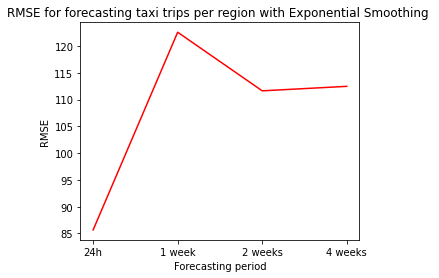

time: 133 ms


In [ ]:
xLabels = ["24h", "1 week", "2 weeks", "4 weeks"]

plt.title('RMSE for forecasting taxi trips per region with Exponential Smoothing ')
plt.xlabel('Forecasting period')
plt.ylabel('RMSE')
plt.plot( xLabels, RMSEArray, 'r')
plt.rcParams["figure.figsize"] = (5,4)
plt.show()

## **Dynamical linear models**

In [ ]:
! pip install pydlm

In [ ]:
startIndex = 0 #24*240
endIndex = 24*304
predictRange = 24*7*4

regionIDSelected = 66
regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)
  
#new flow forecast
y_to_train = newFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex]


time: 3.33 ms


In [ ]:
from pydlm import dlm, trend, seasonality
# A linear trend
linear_trend = trend(degree=1, discount=0.95, name='linear_trend', w=10)
# A seasonality
seasonal52 = seasonality(period=24, discount=0.99, name='seasonal7weeks', w=10)
# Build a simple dlm
simple_dlm = dlm(y_to_train) + linear_trend + seasonal52

time: 6.15 ms


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


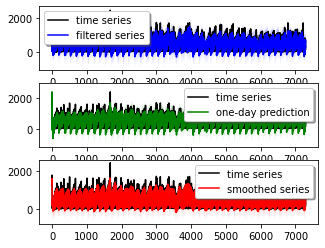

time: 6.28 s


In [ ]:
simple_dlm.fit()
# Plot the fitted results
simple_dlm.turnOff('data points')
simple_dlm.plot()

In [ ]:
print((simple_dlm.getMSE())**0.5)
print()

292.35580965205696

time: 139 ms


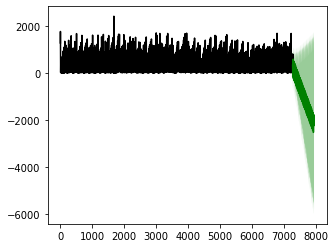

time: 825 ms


In [ ]:
simple_dlm.plotPredictN(date=303*24, N=24*7*4)

In [ ]:
print((simple_dlm.getMSE())**0.5)

259.8337452549325
time: 34.8 ms


## **VARMAX**

In [ ]:
# VARMAX example
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency

startIndex = 0
endIndex = 24*303
predictRange = 24*7*4

regionIDSelected = 66
regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)
  
#new flow forecast
y_to_train_1 = newFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex]
y_to_train_2 = endFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex]

i = 0
y_to_train = []
while i < len(y_to_train_1):
  y_to_train.append([y_to_train_1[i], y_to_train_2[i]])
  i = i + 1

y_exogen = dayTypeEncoding2017[startIndex:endIndex]

# fit model
model = VARMAX(y_to_train, exog=y_exogen)
model_fit = model.fit(disp=False)
# make prediction

data_exog2 = []

for elem in dayTypeEncoding2017[endIndex:endIndex+predictRange]:
  data_exog2.append([elem])

yhat = model_fit.forecast(steps=predictRange, exog=data_exog2)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time: 30.8 s


In [ ]:
def printRMSEforVarmax(predictionRangeValue):
  k = 0
  n = predictionRangeValue
  yhatNewFlow = []
  yhatEndFlow = []
  while k < n:
    yhatNewFlow.append(yhat[k][0])
    yhatEndFlow.append(yhat[k][1])
    k = k + 1

  mseTotal = returnMSESumFor(yhatNewFlow, newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+predictionRangeValue])
  mseTotal = mseTotal + returnMSESumFor(yhatEndFlow, endFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+predictionRangeValue])

  totalTaxiTrips = np.sum(newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+predictionRangeValue])
  totalTaxiTripsMean = totalTaxiTrips / predictionRangeValue

  rmseTotal = (mseTotal/(predictionRangeValue*2))**0.5

  print("Average taxi trips per hour ", totalTaxiTripsMean)
  print("Number of days ", predictionRangeValue/24)
  print("RMSE ", rmseTotal )
  print()

predictionRangeArray = [24, 24*7, 24*7*2, 24*7*4]
print("Forecasting Results for Region ID ", regionIDSelected)
print()
for predictionRangeElem in predictionRangeArray:
  printRMSEforVarmax(predictionRangeElem)


Forecasting Results for Region ID  66

Average taxi trips per hour  423.1666666666667
Number of days  1.0
RMSE  256.0419296733031

Average taxi trips per hour  582.125
Number of days  7.0
RMSE  402.6283099896747

Average taxi trips per hour  596.2440476190476
Number of days  14.0
RMSE  403.5612052901968

Average taxi trips per hour  538.6785714285714
Number of days  28.0
RMSE  389.9650220466283

time: 20.8 ms


Given the results above, RMSE is almost equal to the average taxi trips per hour for the region ID 66, the busiest one. The results are not good and VARMAX is thus dropped from the project. 


After some verifications, VARMAX is not adapted for timeseries with trend and seasonal components. Thus, the relative poor results.

## **Prophet**

In [ ]:
fullDateArray2017.shape

(8760,)

time: 9.84 ms


In [ ]:
startIndex = 0
endIndex = 24*303
predictRange = 24*7*4

regionIDSelected = 26
regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)
  
#new flow forecast
y_to_train_1 = newFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex]
y_to_train_2 = endFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex]

time: 3.33 ms


In [ ]:
def returnDataframeFor(timeseriesArray, fullDateArray):
  df = pd.DataFrame(timeseriesArray)
  df.columns = ["y"]
  df["ds"] = fullDateArray 
  return df

time: 1.98 ms


In [ ]:
dataframeY = returnDataframeFor(y_to_train_1, fullDateArray2017[startIndex:endIndex])
holidaysdataframe = pd.DataFrame()
holidaysdataframe["ds"] = dataframeY["ds"]
holidaysdataframe["holiday"] = dataframeY["ds"]
holidaysdataframe["holiday"] = holidaysdataframe.apply (lambda row: isDateaHoliday(row["ds"]), axis=1)
holidaysdataframe = holidaysdataframe.drop(holidaysdataframe[holidaysdataframe.holiday == ""].index)

time: 134 ms


In [ ]:
holidaysdataframe[:4]

,ds,holiday
0,2017-01-01 00:00:00,Holiday
1,2017-01-01 01:00:00,Holiday
2,2017-01-01 02:00:00,Holiday
3,2017-01-01 03:00:00,Holiday


time: 12.4 ms


In [ ]:
from fbprophet import Prophet

def run_prophet(timeserie, predictionRange = 24*7*4):
    model = Prophet(yearly_seasonality=False,daily_seasonality=True, weekly_seasonality=True, holidays=holidaysdataframe)
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=predictionRange, include_history=False)
    forecast = model.predict(forecast)
    return forecast

time: 3.13 ms


In [ ]:
f = run_prophet(dataframeY)

time: 6.99 s


In [ ]:
results = returnRMSEFor(f.yhat[:24*7], newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+24*7])

print(results)

109.5243261498609
time: 6.55 ms


In [ ]:
predictionRangeArray = [24, 24*7, 24*7*2, 24*7*4]

mseSumArray = [0,0,0,0]

i = 0
n = 20
while i < n:
  regionIDSelected = regionIDsSelected[i][0]
  regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)

  #new flow forecast 
  dataframeY = returnDataframeFor(newFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex], fullDateArray2017[startIndex:endIndex])
  f = run_prophet(dataframeY)

  j = 0
  while j < 4:
    predictionRangeElem = predictionRangeArray[j]
    mseSum = returnMSESumFor(f.yhat[:predictionRangeElem], newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+predictionRangeElem])
    prevMSEValue = mseSumArray[j]
    mseSumArray[j] = prevMSEValue + mseSum
    j = j + 1

  #new flow forecast 
  dataframeY = returnDataframeFor(endFlowTimeSeriesMatrix[regionIDIndex][startIndex:endIndex], fullDateArray2017[startIndex:endIndex])
  f = run_prophet(dataframeY)

  j = 0
  while j < 4:
    predictionRangeElem = predictionRangeArray[j]
    mseSum = returnMSESumFor(f.yhat[:predictionRangeElem], endFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+predictionRangeElem])
    prevMSEValue = mseSumArray[j]
    mseSumArray[j] = prevMSEValue + mseSum
    j = j + 1

  print("region ID ", regionIDSelected)
  print(i+1, "/20")
  print()
  
  i = i + 1


region ID  26
1 /20

region ID  53
2 /20

region ID  60
3 /20

region ID  62
4 /20

region ID  65
5 /20

region ID  66
6 /20

region ID  67
7 /20

region ID  68
8 /20

region ID  72
9 /20

region ID  73
10 /20

region ID  75
11 /20

region ID  76
12 /20

region ID  77
13 /20

region ID  78
14 /20

region ID  80
15 /20

region ID  82
16 /20

region ID  83
17 /20

region ID  88
18 /20

region ID  100
19 /20

region ID  125
20 /20

time: 4min 53s


In [ ]:
j = 0 
RMSEArray= [0, 0, 0, 0]
while j < len(mseSumArray):
  prevValue = mseSumArray[j]
  RMSEArray[j] = (prevValue / (20*2*predictionRangeArray[j]))**0.5
  j = j + 1

print(mseSumArray)
print(RMSEArray)

[15869583.48192865, 137074174.2395664, 298376967.43775976, 1006289505.0136086]
[128.57222144386014, 142.8213660317446, 148.9988832846455, 193.48479401208544]
time: 4.42 ms


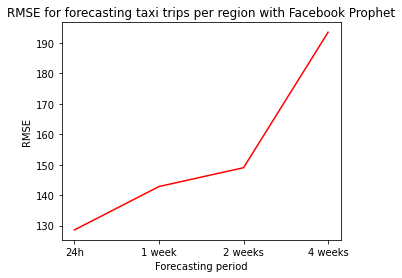

time: 142 ms


In [ ]:
xLabels = ["24h", "1 week", "2 weeks", "4 weeks"]

plt.title('RMSE for forecasting taxi trips per region with Facebook Prophet')
plt.xlabel('Forecasting period')
plt.ylabel('RMSE')
plt.plot( xLabels, RMSEArray, 'r')
plt.rcParams["figure.figsize"] = (5,4)
plt.show()

## **Comparison between all the forecasting methods retained**

In [ ]:
totalFlows = [0, 0, 0, 0]
i = 0
n = 20
while i < n:
  regionIDSelected = regionIDsSelected[i][0]
  regionIDIndex = timeSeriesMatrix.returnIndexForRegionID(regionIDSelected)

  j = 0 
  while j < 4:
    predRange = predictionRangeArray[j] 
    taxitripsNewFlow = np.sum(newFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+ predRange])
    taxitripsEndFlow = np.sum(endFlowTimeSeriesMatrix[regionIDIndex][endIndex:endIndex+ predRange])
    prevValue = totalFlows[j]
    totalFlows[j] = prevValue + taxitripsNewFlow + taxitripsEndFlow
    j = j + 1
  i = i + 1

j = 0 
while j < 4:
  prevValue = totalFlows[j]
  predRange = predictionRangeArray[j] 
  totalFlows[j] = prevValue /(20*2*predRange)
  j = j + 1

print(totalFlows)

[73.2, 93.50014880952381, 94.0453869047619, 83.94605654761905]
time: 34.6 ms


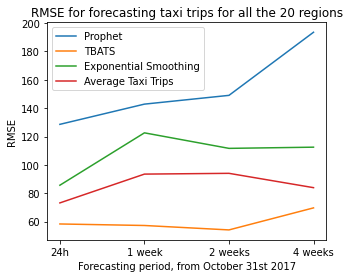

time: 169 ms


In [ ]:
RMSEArrayProphet = [128.57222144386014, 142.8213660317446, 148.9988832846455, 193.48479401208544]
RMSETBATS = [58.354547146888585, 57.28580350309184, 54.165096352630506, 69.69437821470639]
RMSEExpSmo = [85.66843515770087, 122.58325099411775, 111.6415556452773, 112.48023461171171]
xLabels = ["24h", "1 week", "2 weeks", "4 weeks"]

plt.title('RMSE for forecasting taxi trips for all the 20 regions')
plt.xlabel('Forecasting period, from October 31st 2017')
plt.ylabel('RMSE')
plt.plot( xLabels,  RMSEArrayProphet)
plt.plot( xLabels,  RMSETBATS)
plt.plot( xLabels,  RMSEExpSmo)
plt.plot( xLabels,  totalFlows)
plt.legend(['Prophet', 'TBATS', 'Exponential Smoothing', 'Average Taxi Trips'], loc='upper left')
plt.rcParams["figure.figsize"] = (5,4)
plt.show()